## CM32024 / CM52037

## Assessment 1, Part A

# Stochastic Approximation & Bayesian Modelling in Practice


**Total Marks 15 (15% of overall unit grade).**

*Submission deadline: 8pm, Friday December 12. Please submit all your files in Moodle.*


**This is Part A of the first assessment** and represents 15% of the overall unit grade. The accompanying Part B (a "consultancy project"), will be worth 35%. (Assessment 2 next semester will make up the remaining 50% of the unit marks.)

Part A is focused on *Markov Chain Monte Carlo* (MCMC) approximation. It involves implementing and assessing the *Metropolis* sampling algorithm on a standard noisy regression problem, followed by application of the `numpyro` library version of the state-of-the-art HMC algorithm on the same data.

**Important Note!** Although 30 marks are enumerated across the various tasks in this notebook, the overall total will be scaled down (halved!) to give a maximum of 15 marks for this part of the assessment.

## Submission & Marking

For this part of the coursework there are a number of places in this notebook where you are expected to enter your own code.
Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`

Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**.
The workbook you submit must be an `.ipynb` file, which is saved into the
directory you're running Jupyter; alternatively you can download it from the menu above using
`File -> Download`. Remember to save your work regularly
("Save Notebook" in the File menu, the icon of a floppy disk, or Ctrl-S);
**the version you submit should have all code blocks showing the results (if any)
of execution below them**.

### Important!

**You should take care to avoid any suggestion of plagiarism in your submission.**
There is helpful information on "Academic Integrity" and, specifically, how to avoid plagiarism
on the University website: https://www.bath.ac.uk/library/help/infoguides/plagiarism.html

For this coursework, **you may use library code from specific sources only**:
- `numpy`, `scipy`, `matplotlib` and `seaborn` for the core programming and visualisation,
- `numpyro`, `jax` and `arviz` for Task 3.

That said, if you wish to use any alternative libraries, you are welcome to request this via the *Moodle* discussion forum. (All reasonable requests will be considered.)

Note that **the use of Generative AI is not permitted**.

# Assessment 1 Part A: Implementing Stochastic Approximation

This part of the assessment focuses on implementing Monte Carlo sampling for computing useful expectations in the Bayesian linear regression model, using concepts and methodology covered in Lectures 8&ndash;10. Primarily it involves _developing_ your own implementation of the *Metropolis algorithm* (a variant of MCMC) and then _applying_ a library implementation of the more sophisticated *Hamiltonian Monte Carlo* algorithm. It will build on some of the computations undertaken in the weekly lab exercises.

The data studied will be synthetic (generated from randomly weighted basis functions) with additive Gaussian noise of standard deviation $\sigma$. The data is to be modelled with the usual Bayesian linear (in-the-parameters) model, adopting a Gaussian weight prior with hyperparameter $\alpha$, and with Gaussian "RBF" basis functions of unspecified width/radius/length-scale $r$. The primary focus of the tasks here is to generate representative samples of $\alpha$, $r$ and the data noise $\sigma$ that can be used for prediction or other estimation.

There are three principal tasks (detailed below), with varying marks. In summary here:

**Task 1:** Compute and visualise the form of the posterior over hyperparameter $\alpha$ and basis function width $r$, with $\sigma^2$ assumed known at this stage. (3 marks)

**Task 2:** Implement the Metropolis MCMC algorithm to estimate the basis length-scale $r$, for different proposal scales. Extend this to estimation of $\sigma^2$, and ultimately to model weights $\mathbf{w}$, thereby computing a mean predictor (12 marks)

**Task 3:** Employ a software library implementation of the state-of-the-art HMC algorithm, as might be used in real-world applications (or ... Part B!). (15 marks)


## Setup

### Support code

To get started, the code cell below imports the requisite standard modules, plus a setup module `lab_a1_setup` specific to this assessment. It also imports all the same content as that for Lab 03 (Bayesian Linear Regression), along with:
- an implementation of the weight posterior calculation: `compute_posterior`,
- two implementations of the marginal likelihood calculation: `compute_log_marginal_scipy` and `compute_log_marginal_woodbury`.


In [1]:
##
## Setup
##
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance  # Needed for RBF

# Modules required for MCMC
import jax
import jax.numpy as jnp  # Use instead of numpy 'np' in numpyro model functions, e.g. RBF
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
from xarray.core.duck_array_ops import argmax

import seaborn as sns

import scipy.stats as stats

# Lab-specific support module
import lab_a1_setup as setup
from lab_a1_setup import compute_log_marginal_scipy

# Setup for Jax and numpyro
jax.config.update('jax_platforms', 'cpu')
# Uncomment if necessary (hopefully not) - otherwise, jax defaults to 32-bit
# jax.config.update("jax_enable_x64", True)

print(f"Using version {numpyro.__version__} of numpyro")

Using version 0.19.0 of numpyro


We also set some "constants" here: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.2$ for the entire exercise. We will first assume it is known for modelling purposes, then later we will estimate it.

The centres (locations) of the basis functions are fixed here (the length scale, or width, $r$ of those basis functions will be varied during the exercise).


In [2]:
#
# Setup
#
# Define some fixed values
#
# Parameters that determine the generated data
#
sigma = 0.2  # Standard deviation of data observations
sigma_2 = sigma ** 2  # Variance
radius_gen = 1.00  # Generative basis radius or width
#
N_train = 30
N_test = 1000

### Generate Data
We synthesise two data sets:
- a training set of size $N=30$ with added noise of standard deviation $\sigma=0.20$
- a test set of size $N=1000$ with **no noise**, representing the true function

The "input" $x$ data lies in the range $[0, 10]$.

### Generate Basis
For our linear (in-the-parameters) model, we utilise a Gaussian RBF basis function set, where $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. Each basis function has its own center $c_m$; these are equally spaced and will remain fixed. The length scale, or width, $r$ is common across basis functions, and will be varied. There are $N-1$ (29) basis functions, plus a fixed bias.

### Example Model Fit
For an arbitrarily selected set of sub-optimal values of $\alpha$, $\sigma^2$ and $r$, a simple least-squares predictor is computed and graphed below (using `plot_regresssion`) for illustrative purposes. In particular, it also demonstrates how `RBFGenerator` is used (you will need this).


N_train = 30
Empirical σ_train = 0.200
N_test = 1000
[[-0.90310873]
 [ 0.16482774]
 [-0.06567888]
 [ 1.45169134]
 [-2.28813592]
 [ 5.89787861]
 [-7.26961167]
 [ 3.34728465]
 [ 1.22794043]
 [-2.14806439]
 [ 2.39871588]
 [-3.98317828]
 [-1.67665071]
 [ 0.84064601]
 [-2.34595723]
 [ 0.55087405]
 [ 0.32331345]
 [-0.49358776]
 [ 0.03090578]
 [ 0.53276371]
 [-1.7045378 ]
 [ 0.2242439 ]
 [ 1.71603685]
 [-0.5131008 ]
 [ 1.07843767]
 [ 1.82070549]
 [ 1.25581431]
 [ 1.01558326]
 [ 0.29864102]
 [-0.11213789]]


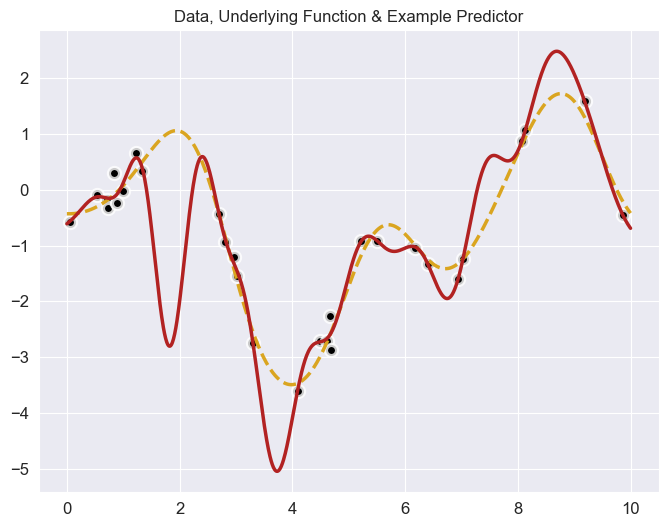

In [3]:
# Generate training data
generator = setup.DataGenerator(r=radius_gen, noise=sigma, seed=20)
x_train, y_train = generator.get_data('TRAIN', N_train)
x_test, y_test = generator.get_data('TEST', N_test)

# Demonstrate use of basis
centres = np.linspace(generator.x_min, generator.x_max, N_train - 1)
radius_model = radius_gen * 0.5  # Example model uses basis functions that are too narrow
RBF = setup.RBFGenerator(centres, radius_model, bias=True)
PHI_train = RBF.evaluate(x_train)
PHI_test = RBF.evaluate(x_test)

# Find quick fit for fixed guess for alpha and known s2
alph = 1e-4
w_pls = np.linalg.inv(PHI_train.T @ PHI_train + alph * np.eye(RBF.M)) @ PHI_train.T @ y_train
fy_test = PHI_test @ w_pls

print(w_pls)

# Show the training data and generating function, plus our mean fit
setup.plot_regression(x_train, y_train, x_test, y_test, fy_test)
plt.title("Data, Underlying Function & Example Predictor");

## Overall Objective

Although there are some varied exercises in this notebook, initially the focus is on  the estimation of a "good" value for the basis function width parameter $r$ given our training data.

As discussed in Lecture 7, this is not a "strictly Bayesian" objective. Ideally, of course, we would make predictions by *integrating* over $r$, but we might imagine that when our model is deployed (as can often be the case in real world applications), there won't be the opportunity to undertake any extended Bayesian computations (*e.g.* running sampling algorithms to calculate predictive distributions in real time). So we are taking a pragmatic viewpoint, and considering how we might find a single good setting for our basis function length-scale. (Later in this notebook, there are cases where we *will* integrate over $r$.)

Our model takes the standard form of $y = \sum_m^M w_m \phi_m(x)$, a linearly-weighted sum of basis functions as defined above: $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. These basis functions have fixed locations $c_m$; but we are free to adjust the common length-scale $r$.

So we will employ our Bayesian techniques now, in the "model development" phase, to determine a good value of $r$ that might be used in any ultimate deployment. Following good Bayesian practice, we will estimate the optimal values by integrating out (averaging over) the other unknowns (the "nuisance variables"). Because most of the integrations are analytically intractable, we will need to utilise the sampling techniques introduced in Lectures 8 and 9, and this aspect is the focus of this part of the coursework.


# Task 1: Computing & Visualising the Hyperparameter Posterior
**3 marks for this task in total.**

**Assume for now that the data noise variance $\sigma^2=0.2^2$ is a known quantity**, and for clarity we will omit it from the probability distribution notation below. We will look at estimating $\sigma^2$ later in Task 2, beginning with the Metropolis MCMC algorithm.


## Task 1a
*1 mark overall*

#### Compute the hyperparameter posterior (1 mark)

The first thing to do is to write a function to compute $p(\alpha, r | \mathbf{y})$, where $\mathbf{y}$ is the training data (vector) `y_train`. Using Bayes' rule:

$$p(\alpha, r | \mathbf{y}) = \frac{p(\mathbf{y}|\alpha,r)\, p(\alpha)\, p(r)}{p(\mathbf{y})}$$

We cannot compute this analytically, as the denominator $p(\mathbf{y})$ is intractable. But to visualise its shape, we can calculate the numerator, which we typically refer to as $P^\ast(\alpha, r)$. The first term in the numerator $p(\mathbf{y}|\alpha,r)$ is the marginal likelihood calculated in a previous lab exercise (though note the dependence on $r$, which will change $\Phi$). The second two terms are priors for $\alpha$ and $r$. These are both *scale parameters*, so it is appropriate to use an uninformative, uniform prior, *on a log scale*. As such, *those terms can be treated as constant and ignored*, provided we work with $\log\alpha$ and $\log r$ in our sampling. So, $p(\alpha, r | \mathbf{y}) \propto p(\mathbf{y}|\alpha,r)$, and we only need compute the latter.

It is suggested that the log p.d.f., $\log p(\alpha, r | \mathbf{y})$, is computed by a function of the form: `log_prob_alph_r_given_y(alph, r, s2, x, y, centres)`. If the probability itself is required, this can be obtained by exponentiating.

This function will need to create a new `RBFGenerator` object and recompute the basis matrix (as this changes with $r$), then call `compute_log_marginal()` as appropriate.


In [4]:
#### **** YOUR CODE HERE **** ####

# Your implementation

def log_prob_alph_r_given_y(alph, r, s2, x, y, centres):
    radius_model = r * 0.75
    RBF = setup.RBFGenerator(centres, radius_model, bias=True)
    
    PHI = RBF.evaluate(x)
    
    logML = setup.compute_log_marginal_scipy(PHI, y, alph, s2)
    
    return logML


## Task 1b
*2 marks overall*

#### Visualise the hyperparameter posterior (1 mark)

Next, you should visualise $p(\alpha, r | \mathbf{y})$, and its logarithm, as implemented in Task 1a.

The following approach is suggested:

- Compute this function over a regular *logarithmic* grid of $\alpha$ and $r$ values
- For consistency and interpretability, use decimal logs (so `foo = np.log10(r)` and `r = 10**foo`)
- Decimal logs apply only to the parameter values: **you should still use natural (exponential) logs for log probabilities!**
- The fixed ranges are:
    - $\log_{10}\alpha \in [-6,+4]$, 100 sampling steps is enough
    - $\log_{10} r \in [-2,+1]$, 100 sampling steps is enough
   
- Visualise the resultant matrix of $\log p(\mathbf{y}|\alpha,r)$ with `plt.contour()` or `plt.contourf()` (**important**: please use logarithmic values for $\alpha$ and $r$)
- Arrange it so that $\log\alpha$ is on the horizontal axis, $\log r$ on the vertical (just for consistency)
- You should find that plotting $\log p(\mathbf{y}|\alpha,r)$ is more informative than plotting $p(\mathbf{y}|\alpha,r)$ - **you should show both**

If all goes to plan, your $\log p(\mathbf{y}|\alpha,r)$ plot, visualised on log-10 scales for $\alpha$ and $r$, should have a maximum (plateau) not very far from the origin (0,0). You should find that plotting $p(\mathbf{y}|\alpha,r)$ is rather uninteresting, but does at least emphasise that the posterior is very "localised".

#### Find the maximum of the hyperparameter posterior (1 mark)

Once you have your visualisation, find its maximum point. Print out or tabulate:
- the maximum value of $\log p(\alpha, r | \mathbf{y})$
- the corresponding most probable $\log\alpha$ and $\log r$ values
- the most probable $\alpha$ and $r$ values (*i.e.* $10^{\log\alpha}$ *etc*)

The most probable value of $r$ should be relatively close to (but not exactly the same as) the generative value of the radius, $r=1.0$.

In [5]:
#### **** YOUR CODE HERE **** ####

log10_alpha_lims = [-6, +4]
log10_r_lims = [-2, +1]

log10_alphas = np.linspace(log10_alpha_lims[0], log10_alpha_lims[1], 100)
log10_rs = np.linspace(log10_r_lims[0], log10_r_lims[1], 100)

alphas = 10 ** log10_alphas
rs = 10 ** log10_rs

logP = np.zeros((len(alphas), len(rs)))

for i, alpha in enumerate(alphas):
    for j, r in enumerate(rs):
        logP[i,j] = log_prob_alph_r_given_y(alpha, r, sigma_2, x_train, y_train, centres)


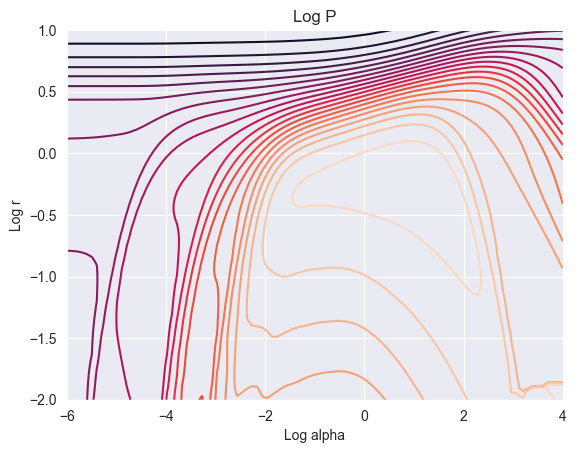

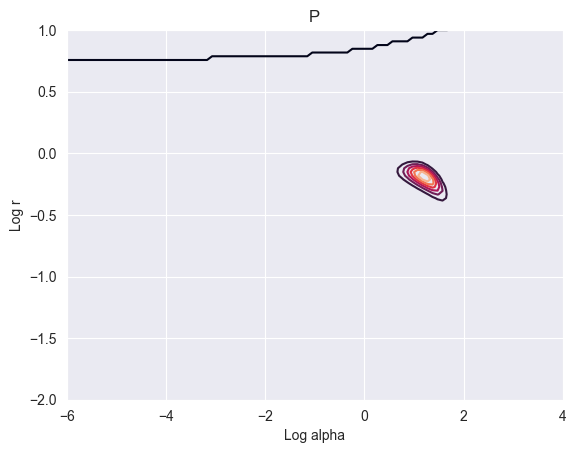

In [6]:
#
X, Y = np.meshgrid(log10_alphas, log10_rs)
Z = logP
eZ = np.exp(logP)

plt.contour(X, Y, Z, levels = 20)
plt.title('Log P')
plt.xlabel('Log alpha')
plt.ylabel('Log r')
plt.show()

plt.contour(X, Y, eZ)
plt.title('P')
plt.xlabel('Log alpha')
plt.ylabel('Log r')
plt.show()
#

In [67]:
# Add some code to print out
# - the maximum value of log p(alpha, r | y)
# - the corresponding most probable log alpha and log r values
# - the most probable alpha and r values (i.e. 10 ** log alpha etc)
max_ar = np.max(logP)
idx = np.argmax(logP)

i_map, j_map = np.unravel_index(idx, logP.shape)

map_log10_alpha = log10_alphas[i_map]
map_log10_r     = log10_rs[j_map]

print(map_log10_alpha)
print(map_log10_r)

0.06060606060606055
0.15151515151515138


### A Note on Reproducibility!

**Important!** As the various sampling algorithms generate random numbers, you should ideally fix your random 'seed' at the outset so that your results are reproducible for individual experiments.

Ideally, you will synchronise your random seeds across both `numpy` and `scipy.stats`. For example:
```python
seed = 1 # Choose your seed as you like!

# This is the old-fashioned way
np.random.seed(seed)
print(stats.uniform.rvs(loc=0, scale=1, size=3))
print(stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1, 0], [0, 1]], size=3))

# This is the "modern" way
rng = np.random.default_rng(seed)
my_gaussian = stats.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
my_gaussian.random_state = rng
print(my_gaussian.rvs(size=3))
print(my_gaussian.rvs(size=3))
# or ...
print(stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1, 0], [0, 1]], size=3, random_state=rng))
```


# Task 2: MCMC & The Metropolis Algorithm
**12 marks for this task in total.**

This task focuses on implementing the Metropolis, MCMC sampling, algorithm, and applying the sampler to find the expected value for basis function width $r$. This is also extended to estimation of the noise variance $\sigma^2$, and then the weights $\mathbf{w}$, which is more challenging.

## Task 2a
*2 marks overall*

#### Implement the Metropolis algorithm (2 marks)

It is suggested that the algorithm be implemented as:

    samples, rejected = metropolis(num_samples, pstar, qrvs, x0)

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x` and returns the corresponding $P^\ast(x)$, for example where `x = [log_alpha, log_r]`
- `qrvs` is a function object which takes a single argument `x` (current state), and generates a single proposal `xdash` sampled from $Q(x'|x)$
- `x0` is the starting state (experiment!), and should be included as the first element of the `samples` that are returned

Overall, the Metropolis implementation should need no more than 20 lines of code, and should return a matrix `samples` containing all the sample vectors (states), along with a matrix `rejected` containing all the proposed states that were *rejected*.

The functions `pstar` and `qrvs` should be defined outside your main `metropolis` function.

**Reminder:** as can be seen in the algorithm specification in the slides (but which is easy to forget!), when a proposal is rejected in the Metropolis algorithm, the current state must be *repeated* within the returned samples list.

In [7]:
my_seed = 1
rng = np.random.default_rng(my_seed)
sigma2_like = 0.2 ** 2 

def pstar(x):
    log_alpha, log_r = x
    return log_prob_alph_r_given_y(np.exp(log_alpha), np.exp(log_r), sigma2_like, x_train, y_train, centres)


def qrvs(x, proposal_sigma_2):
    q_sample = stats.multivariate_normal.rvs(mean = [x[0], x[1]], cov = [[proposal_sigma_2, 0], [0, proposal_sigma_2]], random_state=rng)
    return q_sample

def metropolis(num_samples, pstar, qrvs, x0, proposal_sigma_2):
    samples = []
    rejected = []
    for i in range(num_samples):
        proposed_state = qrvs(x0, proposal_sigma_2)
        k = np.exp(pstar(proposed_state) - pstar(x0))
        u = np.random.rand()
        if k > u:
            samples.append(proposed_state)
            x0 = proposed_state
        else:
            rejected.append(proposed_state)
            samples.append(x0)
    return np.array(samples), np.array(rejected)


## Task 2b
*7 marks overall*

#### Apply the Metropolis sampler to compute $\langle{}r\rangle$ (2 marks)

**Remember to fix your random seeds to make your experiments reproducible (mainly for your benefit).**

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | \mathbf{y})$ investigated above, using MCMC sampling as implemented by your Metropolis algorithm. Assume that $\sigma^2=0.2^2$ is known.

You should use a multivariate Gaussian for $Q$, but experiment with three different length scales (standard deviations):

1. one that is too narrow, which has a very high acceptance rate (anything over 80%), and which "random walks"
2. one too broad, which has a low acceptance rate (say, around 5%)
3. one "just right", with acceptance rate between 20% and 30% (see below hint)

Some degree of "trial and error" is to be expected.

#### Tabulate your results (1 mark)

Once run, produce a tabulation which includes:
- length scale of $Q$
- acceptance rate, which if you have coded it conventionally, should be `(num_samples-len(rejected)) / num_samples`
- the final value of $\langle r \rangle$

#### Visualise the samples (2 marks)

Having run your sampler, _for each proposal_ you should re-create the earlier visualisation of $p(\alpha, r | \mathbf{y})$, with the following additions:
- overlay all the accepted samples in some contrasting colour
- include the rejected proposals too (in a less obvious colour, *e.g.* grey)
- it is suggested you also include the "burn in" samples here (but exclude them when calculating $\langle r\rangle$ - see note below)

#### Plot some diagnostics (2 marks)

For every choice of $Q$ distribution, plot the following:
- the standard graph showing convergence of the $r$ estimate. That is, a graph of $\langle r\rangle$ with increasing time (sample number), as shown in the lecture slides,
- a histogram of the accepted samples of $r$, with a kernel density estimate (KDE) overlayed (it is suggested you use `seaborn.histplot`). **Throw away the "burn-in" samples for this plot.**

The latter plot will mirror the one we will obtain using the `arviz` library in Task 3 shortly.

### Notes & Hints

- You should be able to re-use quite a bit of earlier code for some of the above
- Remember that for MCMC (unlike importance sampling, for example) the proposal depends on the current state
- To compute $\langle r\rangle$ at each sample step, you will need to average the samples up to that step. For every step this can be done in one line of *Python* making use of `np.cumsum`
- Don't forget your samples will be of $\log r$ (along with $\log\alpha$)
- To accommodate "burn in", it is suggested to throw away the first 5% to 10% of samples, then average the rest (but, to make things easier, don't sub-sample)
- It might be illuminating to initialise `x0` at random (within the $\log\alpha, \log r$ grid), or even deliberately badly
- For the purposes of your final visualisations, **initialise at some distance from the maximum**, to more clearly illustrate how the algorithm functions
- A total of 10,000 samples should run in a few seconds, although to save time, you will probably want to use fewer when assessing the length scales (1,000 is fine there). If you're limited for computation, using 5,000 samples is fine
- There is some analysis to suggest that the "ideal" acceptance rate is around 23%
- A high rejection rate means inefficiency and many wasted samples, but too low a rate probably indicates "random walking". You should be able to clearly see this on your visualisations.


In [8]:
# Task 2b
# successive samples are not independent. do i need to just keep every kth sample?


def mcmc(x0, sigma_2s, num_samples, qrvs, pstar):
    acceptance_rates = []
    final_rs = []
    samples_list = []
    rejected_list = []
    r_list = []
    
    for s_2 in sigma_2s:
        samples, rejected = metropolis(num_samples, pstar, qrvs, x0, s_2)
        acceptance_rate = (num_samples - len(rejected)) / num_samples
        burn_in = num_samples // 10
        log_r_samples = samples[:,1]
        r_samples = np.exp(log_r_samples)
        rb_samples = r_samples[burn_in:]
        rs = np.cumsum(rb_samples)
        running_mean = rs / np.arange(1, len(rb_samples)+1)
        final_r = running_mean[-1]
        final_rs.append(final_r)
        acceptance_rates.append(acceptance_rate)
        samples_list.append(samples)
        rejected_list.append(rejected)
        r_list.append(r_samples)
    table = list(zip(sigma_2s, acceptance_rates, final_rs))
    setup.tabulate_neatly(table, headers=["sigma_2", "Acceptance Rate", "R"], title="Metropolis Results")
    return samples_list, rejected_list, r_list

samples, rejected, r_list = mcmc(np.array([0,0]), [0.005, 0.35, 3],10000, qrvs, pstar)  


Metropolis Results

sigma_2,Acceptance Rate,R
0.005,0.8176,1.47194
0.35,0.2132,1.46594
3,0.0467,1.46227


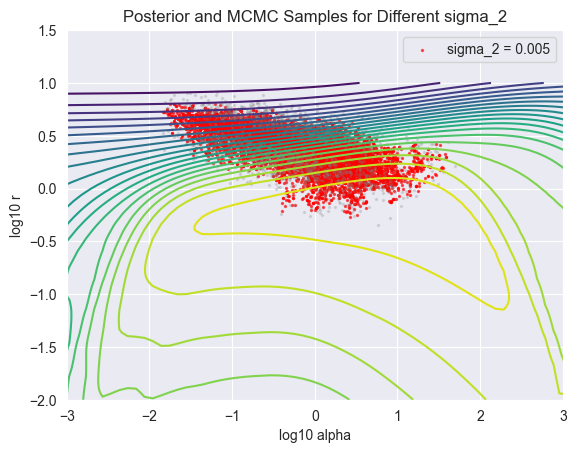

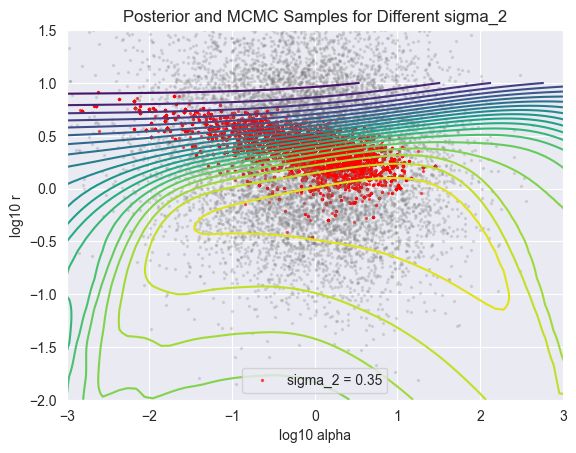

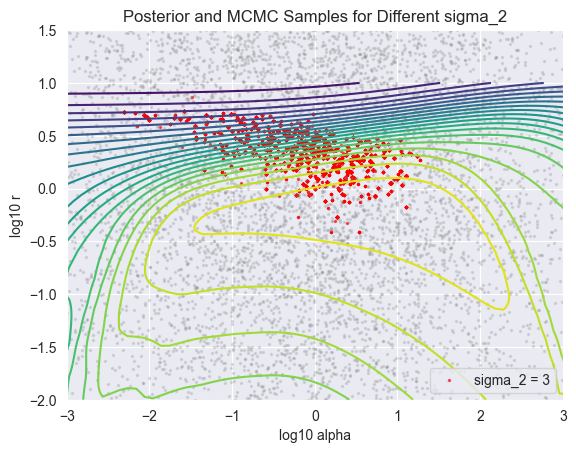

In [9]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(log10_alphas, log10_rs)
Z = logP


labels = ['sigma_2 = 0.005', 'sigma_2 = 0.35', 'sigma_2 = 3']

for i, (s, r) in enumerate(zip(samples, rejected)):
    plt.contour(X, Y, Z, levels=20, cmap='viridis')
    s_array = np.array(s)  # ensure it's an array
    r_array = np.array(r)
    plt.scatter(s_array[:,0], s_array[:,1], color='r', s=2, alpha=0.6, label=labels[i])
    plt.scatter(r_array[:,0], r_array[:,1], color='gray', s=2, alpha=0.2)
    plt.xlim(-3, 3)   # min and max for log10 alpha
    plt.ylim(-2, 1.5) 
    plt.xlabel('log10 alpha')
    plt.ylabel('log10 r')
    plt.title('Posterior and MCMC Samples for Different sigma_2')
    plt.legend()
    plt.show()

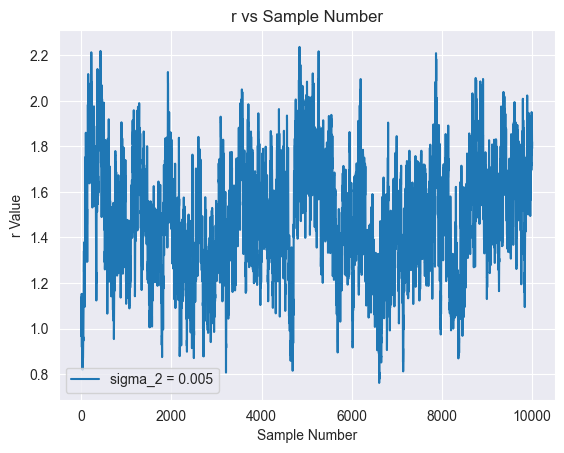

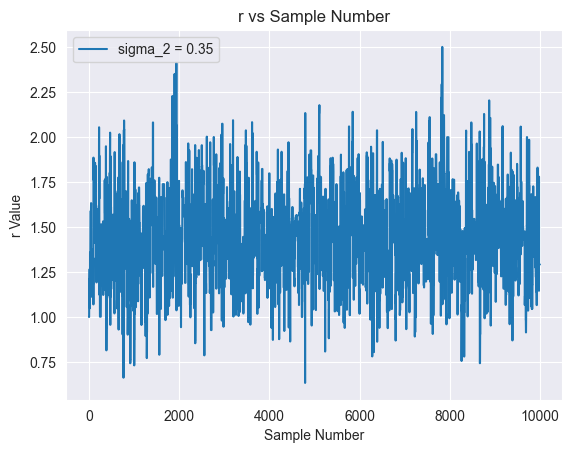

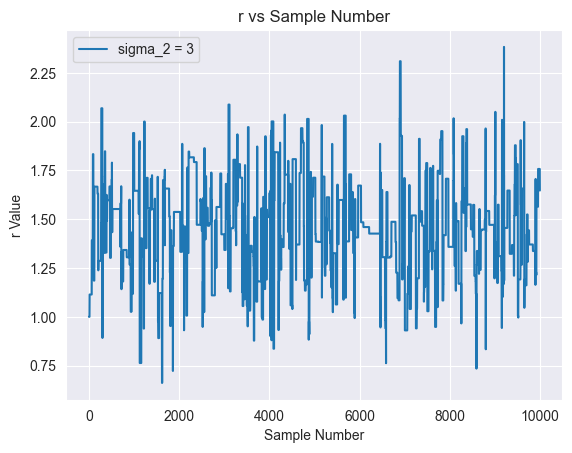

In [10]:
# Plot some diagnostics
for i in range(3):
    sample_numbers = range(0, len(samples[i]))
    
    plt.plot(sample_numbers, r_list[i], label = labels[i])  # marker='o' adds dots
    plt.xlabel('Sample Number')
    plt.ylabel('r Value')
    plt.title('r vs Sample Number')
    plt.legend()
    plt.grid(True)
    plt.show()

<Axes: ylabel='Count'>

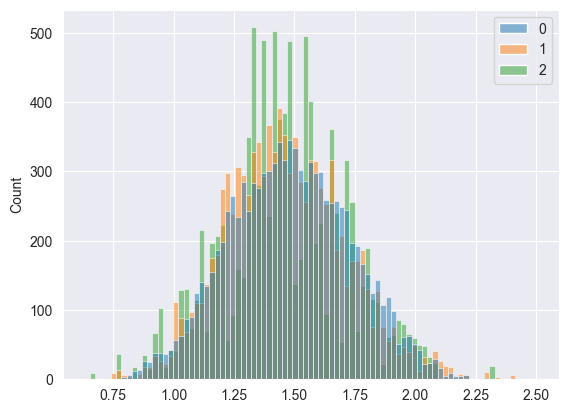

In [11]:
burn_in = len(r_list) // 10

rb_samples = r_list[burn_in:]
sns.histplot(rb_samples)

## Task 2c
*1 mark overall*

#### Extend your Metropolis sampler to estimate the noise level $\sigma$ (1 mark)

Extend the above example to include the noise standard deviation $\sigma$. Assume a uniform log prior as usual, and sample in $\log \sigma$ space. Depending on how you have coded up your sample and proposal functions, this could be a very straightforward task. (You will need to adapt the earlier `pstar` function at this point.)

For this task, you only need to consider a "just right" proposal length scale, which you should find through experiment.

For the output of this task, show the two "diagnostic" graphs as in Task 2b:

- the usual graph showing convergence of the $\sigma$ estimate. That is, a graph of $\langle \sigma \rangle$ with increasing time (sample number),
- a histogram of the accepted samples of $\log\sigma$, with a kernel density estimate (KDE) overlayed (it is suggested you use `seaborn.histplot` again). As above, throw away the "burn-in" samples for this plot.

Also print out the final expectation value (which should be not far from the true value of 0.2).

Metropolis Results

sigma_2,Acceptance Rate,R
0.005,0.7638,1.42544
0.35,0.0933,1.46507
3,0.0094,1.48193


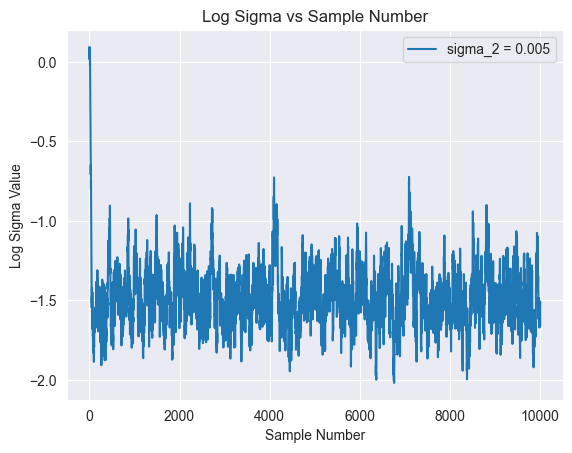

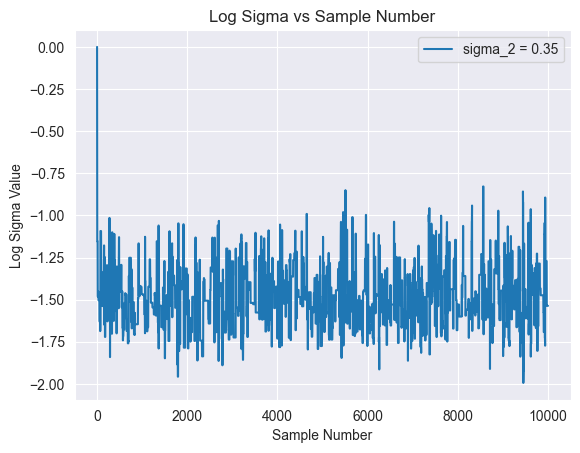

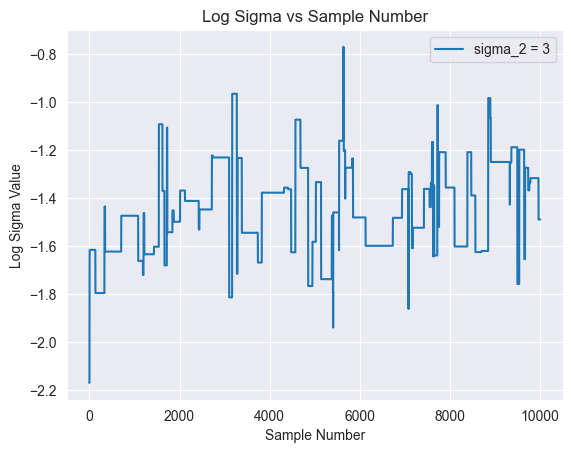

0.22989611054337147


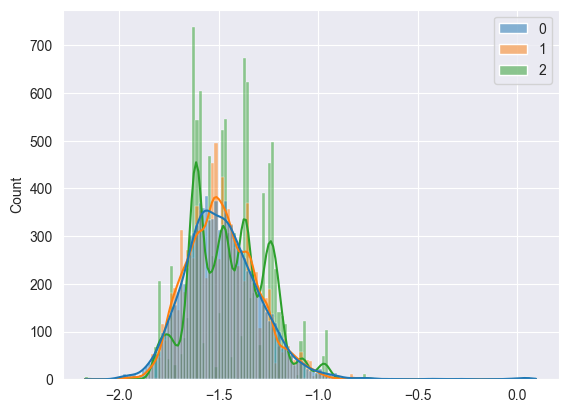

In [12]:
my_seed = 1
rng = np.random.default_rng(my_seed)

def pstar_with_sigma(x):
    log_alpha, log_r, log_sigma = x
    return log_prob_alph_r_given_y(np.exp(log_alpha), np.exp(log_r), np.exp(log_sigma)**2, x_train, y_train, centres)


def qrvs_with_sigma(x, proposal_sigma_2):
    proposal_cov = np.diag([proposal_sigma_2, proposal_sigma_2, proposal_sigma_2])
    q_sample = stats.multivariate_normal.rvs(mean = [x[0], x[1], x[2]], cov = proposal_cov, random_state=rng)
    return q_sample



samples, rejected, r_list = mcmc(np.array([0,0,0]), [0.005, 0.35, 3], 10000, qrvs_with_sigma, pstar_with_sigma)   

log_sigmas_list = [[inner[2] for inner in sublist] for sublist in samples]

for i in range(3):
    sample_numbers = range(0, len(samples[i]))
    
    plt.plot(sample_numbers, log_sigmas_list[i], label = labels[i])
    plt.xlabel('Sample Number')
    plt.ylabel('Log Sigma Value')
    plt.title('Log Sigma vs Sample Number')
    plt.legend()
    plt.grid(True)
    plt.show()

burn_in = len(r_list) // 10

log_sigmas_list_burn_in = log_sigmas_list[burn_in:]
sns.histplot(log_sigmas_list_burn_in, kde = True)

cum = np.cumsum(log_sigmas_list_burn_in)
running_mean = cum / np.arange(1, len(cum)+1)
final_s = np.exp(running_mean[-1])
print(final_s)

In [13]:
# Task 3d

# Extend the Metropolis sampler to model all unknowns and plot a mean predictor

my_seed = 1
rng = np.random.default_rng(my_seed)

def new_log_pstar(x):
    log_alpha, log_r, log_sigma = x
    new_sigma_2 = np.exp(log_sigma) ** 2
    return log_prob_alph_r_given_y(np.exp(log_alpha), np.exp(log_r), new_sigma_2, x_train, y_train, centres)


def qrvs(x, proposal_sigma_2):
    q_sample = stats.multivariate_normal.rvs(mean = x, cov = [[proposal_sigma_2, 0], [0, proposal_sigma_2]], random_state=rng)
    return q_sample

def metropolis(num_samples, pstar, qrvs, x0, proposal_sigma_2):
    samples = []
    rejected = []
    for i in range(num_samples):
        proposed_state = qrvs(x0, proposal_sigma_2)
        k = np.exp(pstar(proposed_state) - pstar(x0))
        u = np.random.rand()
        if k > u:
            samples.append(proposed_state)
            x0 = proposed_state
        else:
            rejected.append(proposed_state)
            samples.append(x0)
    return np.array(samples), np.array(rejected)



## Task 2d (more challenging)
*2 marks overall*

#### Be "strictly Bayesian" and sample all the model unknowns to derive the mean predictor (2 marks)

Extend your Metropolis algorithm to sample over *all* the unknowns in the model: that is, not just $\alpha$, $\sigma$, $r$ as in Task 2c, but also the weights $\mathbf{w}$. This is slightly artificial, in that we don't really need to sample the weights in this model (the posterior over $\mathbf{w}$ is analytically computable), but it demonstrates the principle. In a neural network model (which will be nonlinear in $\mathbf{w}$), we *would* need to sample.

The objective of this task is to plot the "average" predictor at the points `x_test` (you may re-use `plot_regression` for the actual graphing). The quantity to be found is:

$$
\langle \mathbf{y} \rangle = \int (\mathbf{\Phi_\ast} \mathbf{w}) . p(\mathbf{w}, \alpha, r, \sigma^2 | \mathbf{y})\, d\mathbf{w}\, d\alpha\, dr\, d\sigma^2,
$$
where $\mathbf{\Phi_\ast}$ is the basis matrix evaluated at `x_test` (and depends on $r$).

You will need to set up your Metropolis algorithm to sample from $p(\mathbf{w}, \alpha, r, \sigma^2 | \mathbf{y})$. This is of course given by Bayes' rule:

$$
p(\mathbf{w}, \alpha, r, \sigma^2 | \mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{w}, r, \sigma^2)\,p(\mathbf{w}| \alpha)\,p(\alpha)\,p(r)\,p(\sigma^2)}{p(\mathbf{y})}.
$$
From this, we can identify
$$
P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(\mathbf{y}|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)\, p(\alpha)\,p(r)\, p(\sigma^2)
$$
where

- $p(\mathbf{y}|\mathbf{w}, r, \sigma^2)$ is the Gaussian likelihood probability model, with dependence on $r$ made explicit
- $p(\mathbf{w}| \alpha)$ is the Gaussian weight prior 
- $p(\alpha)$, $p(r)$ and $p(\sigma^2)$ are hyperpriors, which if defined as uniform over $\log\alpha$, $\log r$ and $\log\sigma$ respectively, may be considered constant

The state space here will be very high! It is 33-dimensional, due to the 30 weights combined with $\alpha$, $r$ and $\sigma^2$. A relatively narrow Gaussian proposal distribution $Q(\theta^\prime| \theta)$ should work OK, though you may wish to experiment with the length scales. Ideally, you would use _different length scales for the different parameter types_ (that is, one scale for all the weights, and one scale for all the hyper-parameters).

So your approach might be:

- Define $P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(\mathbf{y}|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)$ (all other terms in the numerator being constant and therefore unnecessary) and write a function `new_log_pstar(x)` to calculate posterior where `x` is the 33-dimensional state.
- Use this to generate a set of samples of $\mathbf{w}, \alpha, r, \sigma^2$ using your Metropolis algorithm (use 10,000 samples for your final results)
- Suggest you aim for an acceptance rate of around 25% (not precisely critical)
- For each sample, compute the appropriate basis matrix and subsequent predictor
    - `RBF = setup.RBFGenerator(centres, r)` using sampled $r$
    - `PHI_test = RBF.evaluate(x_test)`
    - `y_pred = PHI_test @ w` using sampled $\mathbf{w}$ and giving a 1000-long vector of predictions at the test points
- Average all the `y_pred` vectors to give the overall mean predictor as  `y_pred_mean`
- At the same time, as a sanity check, you might want to compute $\langle \sigma \rangle$ from the same set of samples, which should be in the region of 0.2 (optional, but easy to do). **If the value of $\sigma$ is far from 0.2, it is a useful indication that the sampler is not working well (scales are sub-optimal).**

In summary, for this task:
- Plot the mean predictor as requested above (following the same format as the example graph "Data, Underlying Function and Example Predictor" earlier in this notebook),
- Print out the noise estimate $\langle \sigma \rangle$.

*If you have done this right, you should find that your predictor is a very good fit to the generating function, taking the limitations of the training data into account.*


In [15]:
# Plot the mean predictor, output the noise estimate

#### **** YOUR PLOTTING CODE HERE **** ####



# Task 3: HMC with NUTS
**15 marks for this task in total.**

This task follows on from that above, addressing the same regression problem with the same data and model. This time, however, we will be employing cutting-edge algorithms from the kind of off-the-shelf library you might apply in advanced real-world analytics: `numpyro`.

### What?

This task centres on applying the *Hamiltonian Monte Carlo* (HMC) algorithm, incorporating the "No U-Turn Sampler" (NUTS), to the dataset above. The sub-tasks require you to:

- Write a `model` function, in the probabilistic programming style
- Visualise that model (no marks for this, but you may find it a useful exercise)
- Use the `numpyro` library to run MCMC using the NUTS ("No U-Turn Sampler") proposal, to obtain samples from the posterior over all the unknowns
- Tabulate posterior estimates for $\alpha$, $\sigma$, and $r$
- Visualise the sampler performance using `arviz`
- Use the weight samples to obtain a predictor function

### Why?

If you attempted Task 2d above, you will probably have needed quite a bit of trial and error to set some of the various algorithmic parameters, notably the scales of the proposal distributions, as well as estimating an appropriate "burn in". In principle, also, we should have sub-sampled the Metropolis output, due to dependence between samples (which we have overlooked for reasons of simplicity). One of the persuasive features of the HMC / NUTS combination is that the algorithm estimates all these factors during a "warm-up" phase, and all the subsequent samples we obtain should be independent. Although there is still scope for things to go wrong (such as with a poorly specified model), this makes libraries such as `numpyro` potentially very powerful tools for Bayesian data science and machine learning.

The main questions left for the 'analyst' are primarily the choice of priors (we address that here), and secondarily, how certain model components are parameterised (this is also important, although we do not consider it here).

### Updating the basis object

To use our RBF object with `numpyro`, we need to write a `jax` compatible version of it. To this end, a new `JRBFGenerator` object is defined below. There are two modifications:
1. All calls to `numpy` (`np`) routines are redirected to the `jax` version `jnp`
2. The basis function radius $r$ is no longer an attribute of the class, but a parameter of `evaluate`. This makes it easier to use in the contexts where we are changing $r$

In [15]:
#
# Basis class that is JAX compatible
# Centres are fixed for evaluation, but radius is parameterised
#
class JRBFGenerator(object):
    """Generate Jax-compatible Gaussian RBF basis
    with parameterised radius"""

    def __init__(self, loci, bias=False):
        self.M = len(loci)
        self.centres = loci.reshape((self.M, 1))
        self.is_bias = bias
        if bias:
            self.M += 1

    def evaluate(self, X, radius):
        N = len(X)
        d2 = distance.cdist(X, self.centres, metric="sqeuclidean")
        JPHI = jnp.exp(-d2 / (radius ** 2))
        if self.is_bias:
            JPHI = jnp.hstack((np.ones((N, 1)), JPHI))
        #
        return JPHI

## Task 3a
*6 marks overall*

#### Implement the Bayesian Linear Regression Model as a Probabilistic Program (6 marks)

Write a function `model(x, y)`, where $x$ is the data input vector and $y$ the training target vector. You should be able to do this clearly in 10 lines of code (but you can use more if required, or if it makes things clearer).

The function will need to specify the distributions  for each variable (or set of variables, in the case of the weights) using `dist` objects within `numpyro.sample` statements. The final output of the model, for which we have observations `y_train`, will also need an `obs` value setting.

How to specify the observation model and prior over $\mathbf{w}$ should be relatively straightforward. It may be less clear as to what hyper-priors you might use for $\alpha$, $\sigma$ and $r$. You are free to adopt your own choices here. That said, in previous examples we have opted for *uniform* priors over a *logarithmic* scale, so this might also be a reasonable approach.

In [25]:

import math

# This can be defined just the once
JRBF = JRBFGenerator(centres, bias=True)

#### **** YOUR CODE HERE **** ####

def model(x, y):
    log_noise_sigma = numpyro.sample('log_sigma', dist.Uniform(jnp.log(1e-3), jnp.log(5.0)))
    noise_sigma = jnp.exp(log_noise_sigma)

    alpha = numpyro.deterministic("alpha", 1.15)

    log_r = numpyro.sample('log_r', dist.Uniform(jnp.log(0.05), jnp.log(0.5)))
    r = jnp.exp(log_r)
    
    with numpyro.plate('weights', 30):
        w = numpyro.sample('w', dist.Normal(0.0, jnp.sqrt(1.0 / alpha)))
        
    PHI = JRBF.evaluate(x, radius=r)
    y_pred = jnp.dot(PHI, w)
    numpyro.sample('obs', dist.Normal(y_pred, noise_sigma), obs=y)

## Task 3b

**This task is optional, and there are no marks!**

It is nevertheless a useful exercise, but it requires installing non-*Python* executable code, so may be skipped.

### Visualise your model structure

In the below cell, render your above model in the standard "probabilistic graphical model" (PGM) format using `numpyro`'s built-in functionality. This is a handy way of verifying that your model is correctly defined, makes sense, and is structured how you think it is.

### Dependencies

See: https://num.pyro.ai/en/stable/tutorials/model_rendering.html

Model rendering is straightforward and only requires a single function call, **but** it does require that you have a library called `graphviz` appropriately installed, **both the Python module and the system executables**. This latter requirement may be problematic for some (*e.g.* those using University computers), which is why this exercise is optional.

For the Python library (in your appropriate environment of course), on all platforms:

```pip install graphviz```

For the executables, on Linux (Debian-based):

```sudo apt install graphviz```

For Windows and Mac, see: https://graphviz.org/download/

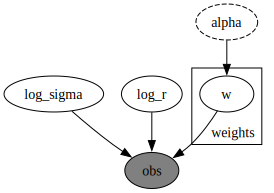

In [26]:
#### **** YOUR CODE HERE **** ####

numpyro.render_model(model, model_args=(x_train, y_train), render_params=True, filename="model.pdf")

## Task 3c
*3 marks overall*

#### Run the HMC Sampler (2 marks)

Using the "No U-Turn Sampler" (NUTS) Kernel, run MCMC on your model for the training set. It is suggested, but not critical, that you use 500 "warm up" iterations and then obtain 1,000 actual samples. This may take around 10 seconds to run.

The code to do this is fairly straightforward, just a few lines, although you will have to remember to pass in an appropriate random number generator key.

#### Print out the MCMC Summary (1 mark)

Print out a summary of the inference using the built-in functionality of the `MCMC` class. If all is well, you should see that there are zero "divergences" and that `r_hat` is 1.00 (or very, very close) for all variables.

You may notice though that the number of effective samples `n_eff` is considerably lower for the more "indirect" quantities, $\alpha$ and $r$.

In [27]:
#### **** YOUR CODE HERE **** ####

num_warmup = 500
num_samples = 1000

p_seed = 0
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup)
rng_key = jax.random.key(p_seed)
mcmc.run(rng_key, x_train, y_train)
mcmc.print_summary()



sample: 100%|██████████| 1500/1500 [00:04<00:00, 343.29it/s, 39 steps of size 4.36e-01. acc. prob=0.87] 


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      log_r     -2.88      0.10     -2.91     -3.00     -2.75    915.55      1.00
  log_sigma      0.22      0.03      0.22      0.18      0.26   1358.39      1.00
       w[0]     -0.87      0.05     -0.87     -0.96     -0.79    868.75      1.00
       w[1]     -0.02      0.45     -0.02     -0.75      0.70   1002.29      1.00
       w[2]     -0.02      0.95     -0.03     -1.44      1.62    710.32      1.00
       w[3]     -0.01      0.17     -0.01     -0.30      0.25    854.27      1.00
       w[4]     -0.02      0.84     -0.06     -1.35      1.32    981.76      1.00
       w[5]     -0.01      0.84      0.01     -1.39      1.34    812.41      1.00
       w[6]      0.01      0.92     -0.02     -1.49      1.45   1158.70      1.00
       w[7]     -0.01      0.90      0.01     -1.51      1.40    880.69      1.00
       w[8]     -0.03      0.91     -0.04     -1.74      1.23    833.31      1.00
       w[9]    

In [28]:
samples = mcmc.get_samples()
print(samples.keys())
print(samples["log_r"].min())
print(samples["log_r"].max())


dict_keys(['alpha', 'log_r', 'log_sigma', 'w'])
-2.9956024
-2.3160598


## Task 3d
*2 marks overall*

#### Tabulate posterior estimates (2 marks)

Given the samples from your MCMC run above, calculate and print a table of posterior mean estimates for $\alpha$, $\sigma$ and $r$, both the log values (as sampled) and the transformed (true) values (*i.e.* 10 to the power of the mean log values). For $\sigma$ and $r$, also include the "true" generative values in the table (as defined in the `# Setup` code cell earlier). It is suggested that you use the `tabulate_neatly` helper function here.

In [29]:
#### **** YOUR CODE HERE **** ####
print("Samples: ")
values = []
keys = []
means = []

for key, value in samples.items():
    print(f"\t{key:6s}", value.shape)
    values.append(np.exp(value))
    keys.append(key)

for key in samples.keys():
    mean = jnp.mean(jnp.array(samples[key]))
    means.append(mean)

print(means)


Samples: 
	alpha  (1000,)
	log_r  (1000,)
	log_sigma (1000,)
	w      (1000, 30)
[Array(1.15, dtype=float32), Array(-2.8793314, dtype=float32), Array(0.22127359, dtype=float32), Array(-0.02844554, dtype=float32)]


## Task 3e
*2 marks overall*

#### Assess the performance of the sampler (2 marks)

Use `arviz` to plot the 'trace' of the samples of all the parameters, which also includes a kernel density estimate (KDE). That should give you four sets of two graphs (`arviz` will superimpose the 30 weight parameters onto single plots if `compact=True`, which is recommended!).

On the left is a KDE of the samples, on the right is the 'trace', which is the value of the samples at each iteration. For the hyper-parameters (logs of $\alpha$, $\sigma$ and $r$), this will give graphs analogous to those you should have manually generated in Task 2b earlier.

Evidence that things have gone wrong might be:
- the weight samples (left) do not look approximately Gaussian
- the hyper-parameter distributions (left) are multi-modal or highly skewed
- the traces (right) do not look like random noise, but have "structure" (often seen in conjunction with multi-modal KDE plots, as samples transition between modes)
- divergences appear (left)

Generally, the duller the plots are, the more likely the sampler is to have run well!



C:\Python313\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'log_r'}>,
        <Axes: title={'center': 'log_r'}>],
       [<Axes: title={'center': 'log_sigma'}>,
        <Axes: title={'center': 'log_sigma'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

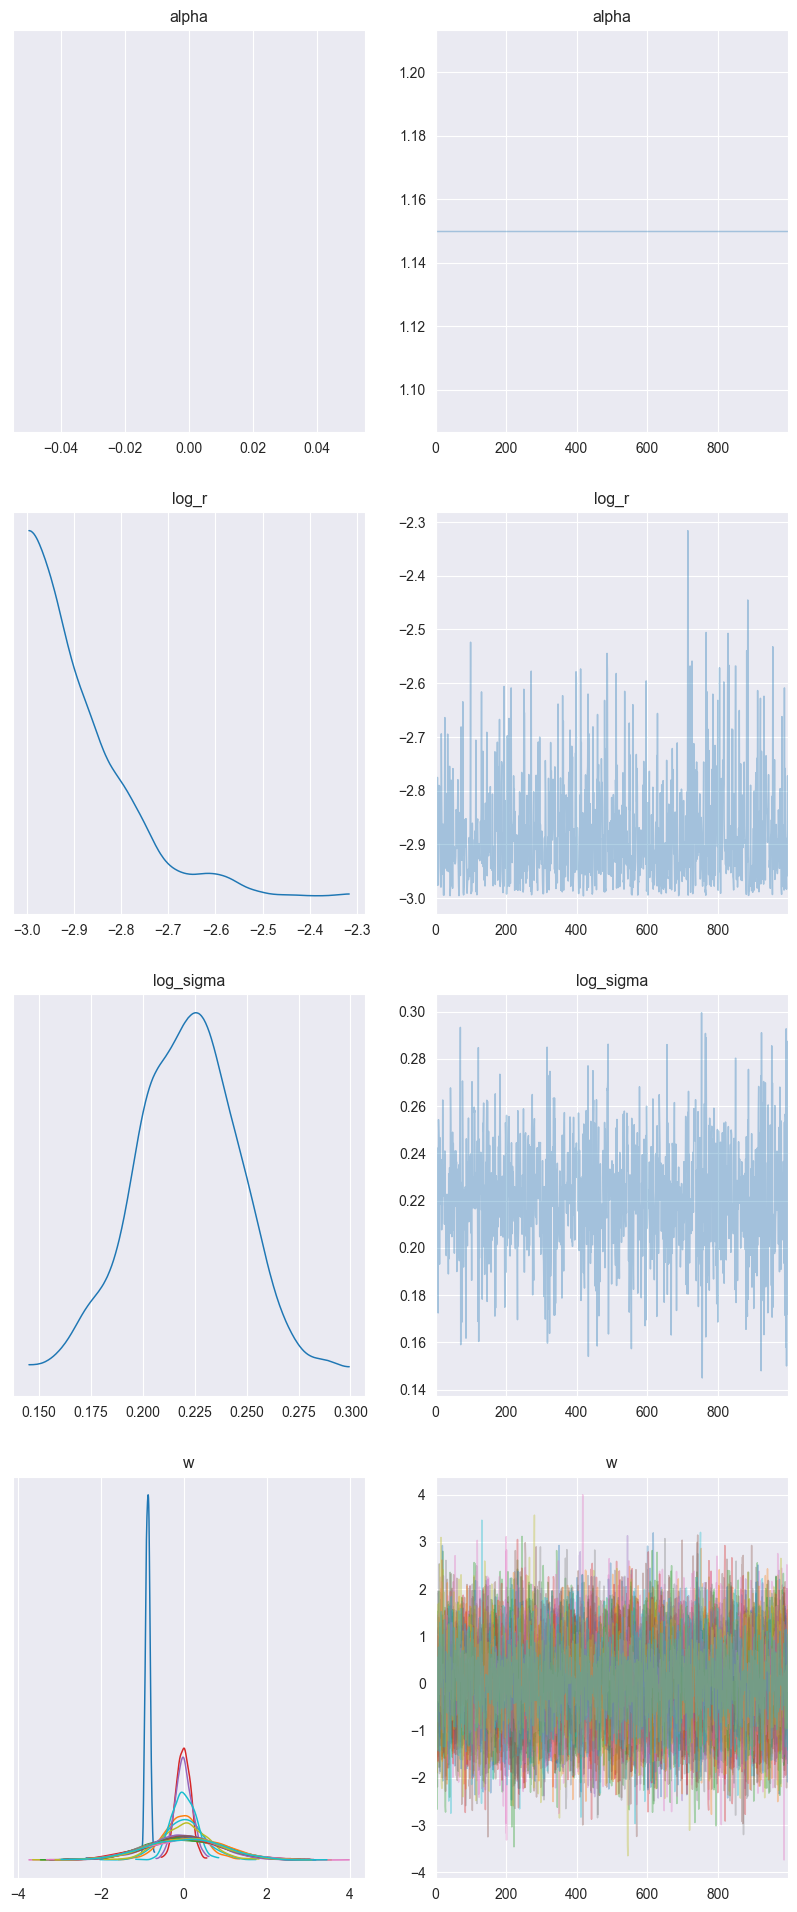

In [30]:
#### **** YOUR CODE HERE **** ####
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(10,24))


## Task 3f
*2 marks overall*

Finally, presuming our sampler has operated to our satisfaction, we come to our ultimate objective: to use our samples to make predictions. There are two main ways we could do this:
1. pragmatically, and,
2. correctly!

We'll do both. For this final sub-task, compute the model predictions for the 1,000 test points `x_test` **adopting the two approaches outlined below**. In both cases:
- plot the training data, true function and the predictions (exactly as before) with `plot_regression`
- calculate the RMS test error (use `error_rms` as previously) and either print out or incorporate in the graph title

The "pragmatic" predictor will be much more computationally efficient if deployed, but while both predictors will appear very reasonable, you will probably find that your "correct" predictor exhibits the lower test error (though this is not always guaranteed).

#### Pragmatic: Obtain and evaluate predictions for the test set based on a single set of average parameters (1 mark)

The most computationally efficient predictions might arguably be derived from evaluating the model using one single set of weights (the average of the samples) and the basis functions evaluated with the single posterior mean radius $r$ (giving a single `PHI_test` matrix).

#### Correct: Obtain and evaluate predictions for the test set by averaging over all individual (per-sample) predictions (1 mark)

The "correct" Bayesian thing to do would be to *average every individual prediction*. That is, for each sample, compute the basis matrix `PHI_test` for the respective $r$ and multiply by the corresponding sample of the weights, to obtain a prediction $\mathbf{y}$ *specific to that sample*. Then *average* all the prediction vectors $\mathbf{y}$, one for each sample, to produce an overall single prediction vector. This is clearly more computationally expensive, but also more "strictly Bayesian".


[0.42050865 1.083929   1.559014   1.0058953  1.4095093  1.3936982
 1.5504036  1.4675525  1.4792336  1.127168   1.462706   1.5473726
 1.540389   1.5278207  1.0132024  1.6334113  1.6137801  1.5622612
 1.1864277  1.035013   1.4699473  1.5612333  1.5324055  1.4669331
 1.3531054  1.5423428  1.6396139  1.5071124  1.55335    1.5548451 ]
1.2480634
(30,)


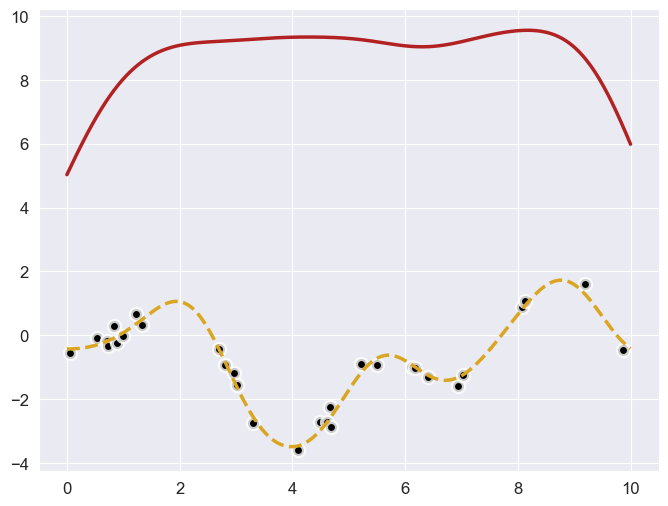

In [31]:
#### **** YOUR CODE HERE **** ####
weights = np.array(values[3])
w_means = np.mean(weights, axis=0)

print(w_means)

r_vals = np.array(values[2])
r_mean = np.mean(r_vals)

print(r_mean)

PHI_test = JRBF.evaluate(x_test, radius=r_mean)  # radius is sampled r
print(w_means.shape)

y_pred = np.array(jnp.dot(PHI_test, w_means))
# Pragmatic predictions

setup.plot_regression(x_train, y_train, x_test, y_test, y_pred, figsize=(10,24))


In [23]:
def model_2(x, y):
    noise_sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))

    # log-alpha prior
    log_alpha = numpyro.sample("log_alpha", dist.Uniform(-5.0, 5.0))
    alpha = jnp.exp(log_alpha)

    r = 0.18

    with numpyro.plate("weights", 30):
        w = numpyro.sample("w", dist.Normal(0.0, jnp.sqrt(1 / alpha)))

    PHI = JRBF.evaluate(x, radius=r)
    y_pred = jnp.dot(PHI, w)

    numpyro.sample("obs", dist.Normal(y_pred, noise_sigma), obs=y)


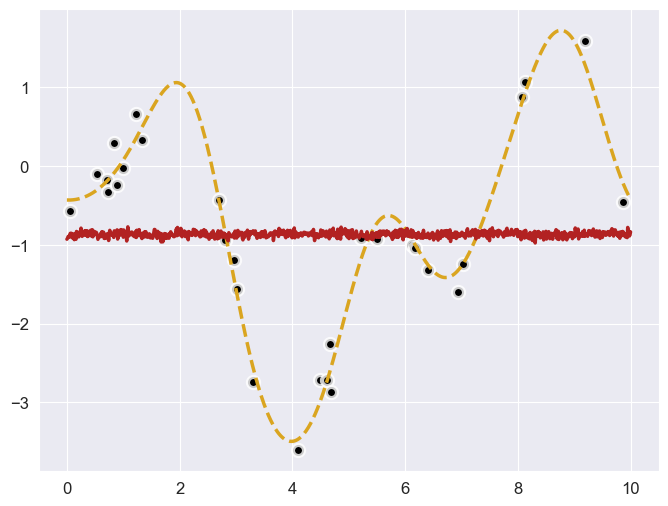

In [24]:
#### **** YOUR CODE HERE **** ####
from numpyro.infer import Predictive

# Bayesian predictions
# Use the fitted MCMC samples
predictive = Predictive(model_2, posterior_samples=samples, return_sites=["obs"])
y_pred_samples = predictive(rng_key, x=x_test, y=None)["obs"]

# Compute posterior mean prediction
y_pred_mean = jnp.mean(y_pred_samples, axis=0)

# Compute 95% credible intervals
y_pred_lower = jnp.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = jnp.percentile(y_pred_samples, 97.5, axis=0)

# Plot
setup.plot_regression(x_train, y_train, x_test, y_test, y_pred_mean,
                      y_lower=y_pred_lower, y_upper=y_pred_upper, figsize=(10,24))

In [25]:
centres_sorted = np.sort(centres)
d = np.mean(np.diff(centres_sorted))  # average distance between centres
r_fixed = 0.5 * d                     # cover half the spacing
print("Suggested r:", r_fixed)

x_scaled = (x - x.min()) / (x.max() - x.min())
centres_scaled = (centres - x.min()) / (x.max() - x.min())



Suggested r: 0.1785714285714286
